<h4>I want to understand how was the evolution of the dolar price in my country</h4>

In [1]:
import requests
from requests.exceptions import HTTPError
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

*Get the data from 01-01-2010 until "today" 07-05-2021*

In [2]:
jsonResponse = None

try:
    url = 'https://mercados.ambito.com//dolar/informal/historico-general/01-01-2010/15-05-2021'

    response = requests.get(url)
    response.raise_for_status()
    jsonResponse = response.json()

except HTTPError as http_err:
    print(f'HTTP error occurred: {http_err}')
except Exception as err:
    print(f'Other error occurred: {err}')

*Remove the first element that are the headers for the "table"*

In [3]:
jsonResponse.pop(0)

['Fecha', 'Compra', 'Venta']

In [4]:
jsonResponse = np.char.replace(jsonResponse, ',', '.')

*Create the DataFrame*

In [5]:
df = pd.DataFrame(jsonResponse, columns =['Fecha', 'Compra', 'Venta'])

In [6]:
df.head()

,Fecha,Compra,Venta
0,06-05-2021,145.00,151.00
1,05-05-2021,146.00,151.00
2,04-05-2021,149.00,154.00
3,03-05-2021,148.00,153.00
4,30-04-2021,145.00,150.00


*Plot the values from the last 90 entries*

In [7]:
last_90_compra = df['Compra'][:90].astype(float)
last_90_compra = last_90_compra[::-1]
last_90_venta = df['Venta'][:90].astype(float)
last_90_venta = last_90_venta[::-1]
last_90_fecha = df['Fecha'][:90]
last_90_fecha = last_90_fecha[::-1]

compra_min = last_90_compra.min()
compra_max = last_90_compra.max()
venta_min = last_90_venta.min()
venta_max = last_90_venta.max()

min_val = compra_min if compra_min < venta_min else venta_min
max_val = compra_max if compra_max > venta_max else venta_max

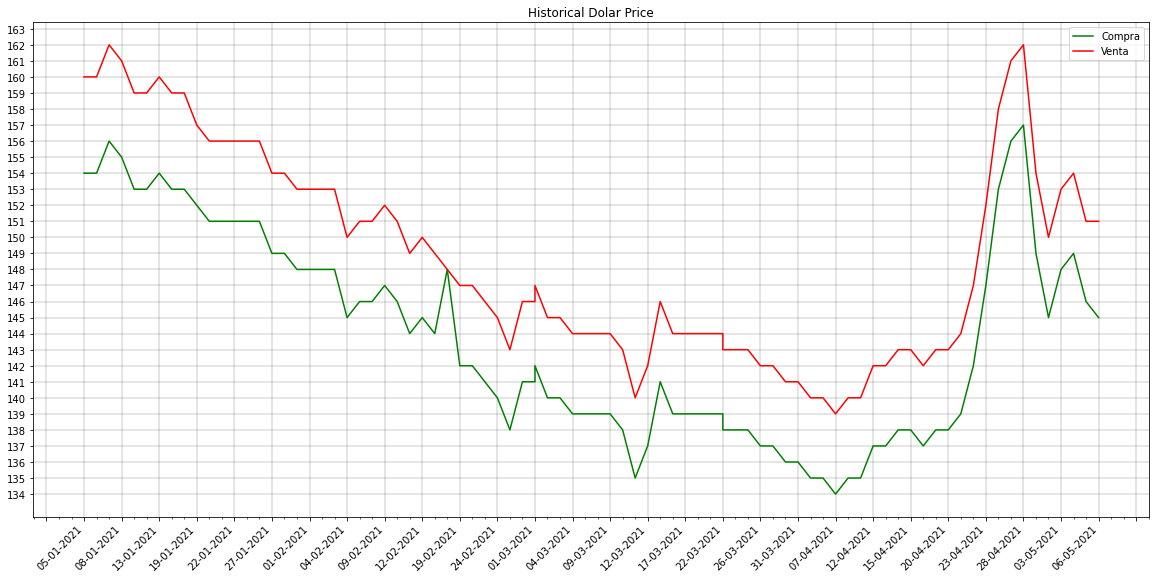

In [8]:
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(211)
ax.plot(last_90_fecha, last_90_compra, color = 'green', label = 'Compra')
ax.plot(last_90_fecha, last_90_venta, color = 'red', label = 'Venta')
ax.set_title("Historical Dolar Price", color = 'black')
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ticks_range = np.arange(min_val, max_val + 2)
plt.yticks(ticks_range)
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

<h4>Try to predict the price</h4>

In [10]:
data=df.sort_index(ascending = False, axis = 0)
data['Fecha'] = pd.to_datetime(data['Fecha'], dayfirst=True)
new_dataset=pd.DataFrame(index = range(0, len(data)), columns = ['Fecha','Compra'])

for i in range(0,len(data)):
    new_dataset["Fecha"][i] = data.Fecha[i]
    new_dataset["Compra"][i] = float(data["Compra"][i])
    
new_dataset.index = new_dataset.Fecha
new_dataset.drop("Fecha", axis = 1, inplace = True)
new_dataset = new_dataset[::-1]

print(new_dataset.head())
print(data.head())

           Compra
Fecha            
2010-01-04   3.86
2010-01-05   3.86
2010-01-06   3.87
2010-01-07   3.86
2010-01-08   3.87
          Fecha Compra Venta
2771 2010-01-04   3.86  3.86
2770 2010-01-05   3.86  3.86
2769 2010-01-06   3.87  3.88
2768 2010-01-07   3.86  3.87
2767 2010-01-08   3.87  3.87


In [11]:
scaler = MinMaxScaler(feature_range = (0, 1))
final_dataset = new_dataset.values

data_size_85 = int(final_dataset.shape[0] * 0.85)

train_data = final_dataset[0:data_size_85,:]
valid_data = final_dataset[data_size_85:,:]

scaled_data = scaler.fit_transform(final_dataset)

x_train_data, y_train_data = [],[]

for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

In [12]:
lstm_model = Sequential()
lstm_model.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train_data.shape[1],1)))
lstm_model.add(LSTM(units = 100, return_sequences = True))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dense(1))

inputs_data = new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_data, y_train_data, epochs = 1, batch_size = 1, verbose = 2)

X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

2296/2296 - 258s - loss: 1.9397e-04


/home/mauro/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


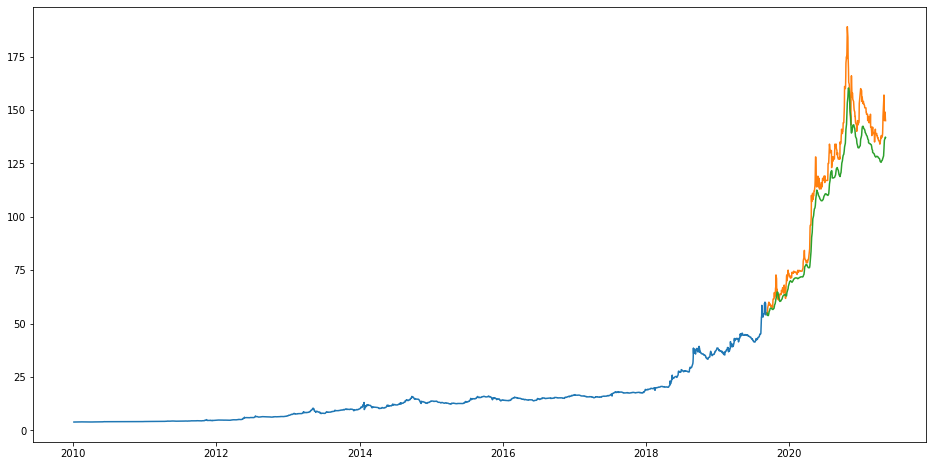

In [13]:
train_data = new_dataset[:data_size_85]
valid_data = new_dataset[data_size_85:]
valid_data['Predictions'] = predicted_closing_price
plt.figure(figsize=(16,8))
plt.plot(train_data['Compra'])
plt.plot(valid_data[['Compra', 'Predictions']])

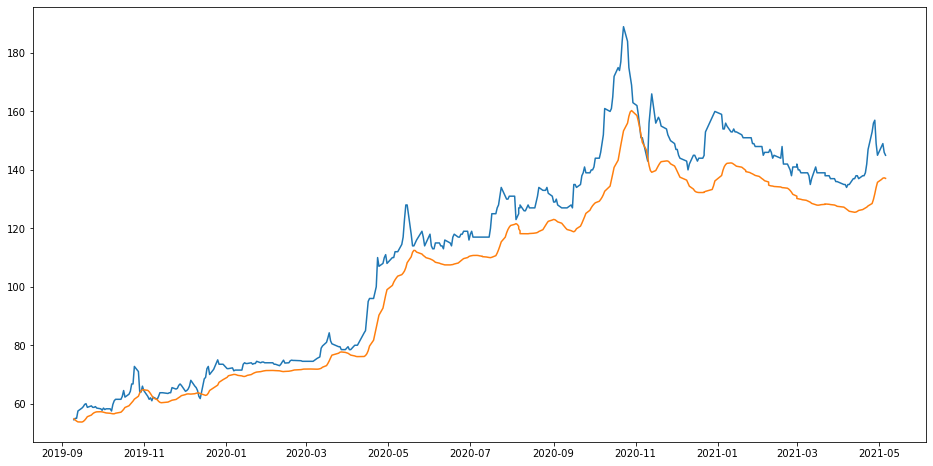

In [14]:
plt.figure(figsize=(16,8))
plt.plot(valid_data[['Compra', 'Predictions']])